In [4]:
import pandas as pd
import open3d as o3d
import numpy as np
import csv
import copy
import scipy
import os
import cv2

from PIL import Image
from matplotlib import pyplot as plt

import sys
sys.path.append('../')

from utils import pg

In [ ]:
ZED_data = '../../data/ZED/vga/point_cloud_PLY_3029_376_06-12-2022-19-40-31.ply'
LiDAR_data = '../../data/lidar/600/2022-12-10-16-54-57_Velodyne-VLP-16-Data.csv'

print(os.path.exists(ZED_data), os.path.exists(LiDAR_data))

True True


In [ ]:
with open(LiDAR_data, newline='') as f:
    rows = list(csv.reader(f, delimiter=',', quotechar='"'))
    pts_lidar = np.zeros(shape=(len(rows) - 1, 3))
    headers = rows.pop(0)
    for index, row in enumerate(rows[1:]):
        # print(index, row[0])
        pts_lidar[index] = row[0:3]

In [ ]:
pcd_lidar = o3d.geometry.PointCloud()
pcd_lidar.points = o3d.utility.Vector3dVector(pts_lidar)
pts_lidar = np.asarray(pcd_lidar.points)
print(pts_lidar, pts_lidar.shape)

[[ 1.12793827e-02  4.97123003e+00  8.67733657e-02]
 [ 1.03042442e-02  4.21706104e+00 -9.73588169e-01]
 [ 1.22444713e-02  5.01110792e+00  2.62621820e-01]
 ...
 [-2.08086218e-03  1.98707628e+00  2.43982419e-01]
 [ 4.43646731e-03  1.95531094e+00  2.40082607e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]] (8707, 3)


In [ ]:
def pts_to_img(point_cloud_data, image_resolution=(256, 256)):
    # Define the resolution of the image
    image_resolution = (512, 512)

    # Determine the range of values for each axis
    x_range = np.max(point_cloud_data[:, 0]) - np.min(point_cloud_data[:, 0])
    y_range = np.max(point_cloud_data[:, 1]) - np.min(point_cloud_data[:, 1])
    z_range = np.max(point_cloud_data[:, 2]) - np.min(point_cloud_data[:, 2])

    # Rescale the values for each axis to fit within the image resolution
    x_scaled = (point_cloud_data[:, 0] - np.min(point_cloud_data[:, 0])) / x_range * (image_resolution[0] - 1)
    y_scaled = (point_cloud_data[:, 1] - np.min(point_cloud_data[:, 1])) / y_range * (image_resolution[1] - 1)
    z_scaled = (point_cloud_data[:, 2] - np.min(point_cloud_data[:, 2])) / z_range

    # Create the image array and set pixel values based on the 3D coordinates
    image_array = np.zeros(image_resolution, dtype=np.uint8)
    for i in range(len(x_scaled)):
        image_array[int(y_scaled[i]), int(x_scaled[i])] = int(z_scaled[i] * 255)
    
    return image_array

In [ ]:
def pts_to_img2(point_cloud_data, camera_pos, camera_orient,fov , image_resolution=(256, 256)):
    # Define the camera pose matrix
    R = cv2.Rodrigues(camera_orient)[0]
    T = np.array(camera_pos).reshape((3,1))
    M = np.hstack((R, T))
    M = np.vstack((M, np.array([0,0,0,1])))
    M_inv = np.linalg.inv(M)

    # Transform the point cloud data into the camera coordinate system
    point_cloud_data_hom = np.hstack((point_cloud_data, np.ones((point_cloud_data.shape[0], 1))))
    point_cloud_data_cam_hom = np.dot(M_inv, point_cloud_data_hom.T).T[:,:3]

    # Project the transformed data onto the image plane
    f = image_resolution[0] / 2.0 / np.tan(fov/2)
    img_pts = np.dot(point_cloud_data_cam_hom, np.array([[f, 0, 0], [0, f, 0], [0, 0, 1]]).T)
    img_pts[:, :2] /= img_pts[:, 2:3]
    img_pts[:, 0] += image_resolution[0] / 2.0
    img_pts[:, 1] += image_resolution[1] / 2.0
    img_pts = img_pts[:, :2].astype(np.int32)

    # Create the image array and set pixel values based on the projected points
    image_array = np.zeros(image_resolution, dtype=np.uint8)
    for i in range(len(img_pts)):
        if (img_pts[i, 0] >= 0 and img_pts[i, 0] < image_resolution[0] and
            img_pts[i, 1] >= 0 and img_pts[i, 1] < image_resolution[1]):
            image_array[img_pts[i, 1], img_pts[i, 0]] = int(point_cloud_data[i, 2] * 255)

    return image_array

In [ ]:
def pts_to_img3(point_cloud_data, camera_pos, camera_orient, fov, image_resolution):
    # Define the camera pose matrix
    R = cv2.Rodrigues(camera_orient)[0]
    T = np.array(camera_pos).reshape((3,1))
    M = np.hstack((R, T))
    M = np.vstack((M, np.array([0,0,0,1])))
    M_inv = np.linalg.inv(M)

    # Transform the point cloud data into the camera coordinate system
    point_cloud_data_hom = np.hstack((point_cloud_data, np.ones((point_cloud_data.shape[0], 1))))
    point_cloud_data_cam_hom = np.dot(M_inv, point_cloud_data_hom.T).T[:,:3]

    # Project the transformed data onto the image plane
    aspect_ratio = image_resolution[1] / image_resolution[0]
    f = 1.0 / np.tan(fov / 2)
    img_pts = np.dot(point_cloud_data_cam_hom, np.array([[f, 0, 0], [0, f / aspect_ratio, 0], [0, 0, 1]]).T)
    img_pts[:, :2] /= img_pts[:, 2:3]
    img_pts[:, 0] += image_resolution[0] / 2.0
    img_pts[:, 1] += image_resolution[1] / 2.0
    img_pts = img_pts[:, :2].astype(np.int32)

    # Create the image array and set pixel values based on the projected points
    image_array = np.zeros(image_resolution, dtype=np.uint8)
    for i in range(len(img_pts)):
        if (img_pts[i, 0] >= 0 and img_pts[i, 0] < image_resolution[0] and
            img_pts[i, 1] >= 0 and img_pts[i, 1] < image_resolution[1]):
            image_array[img_pts[i, 1], img_pts[i, 0]] = int(point_cloud_data[i, 2] * 255)

    return image_array

255


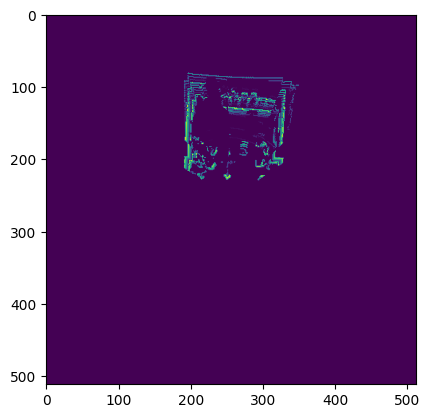

In [ ]:
# dept_lidar = pts_to_img(pts_lidar)

camera_pos = (0, 0, 10)
camera_orient = (0, 0, 0)
image_resolution = (512, 512)

dept_lidar = pts_to_img2(pts_lidar, camera_pos, camera_orient, np.pi/2, image_resolution)
print(dept_lidar.max())
plt.imshow(dept_lidar)

In [ ]:
pcd_lidar_r = copy.deepcopy(pcd_lidar).translate((0, 0, 0))
pcd_lidar_r.rotate(pcd_lidar_r.get_rotation_matrix_from_xyz((-np.pi / 2, 0, 0)), center=(0, 0, 0))
pts_lidar_r = np.asarray(pcd_lidar_r.points)

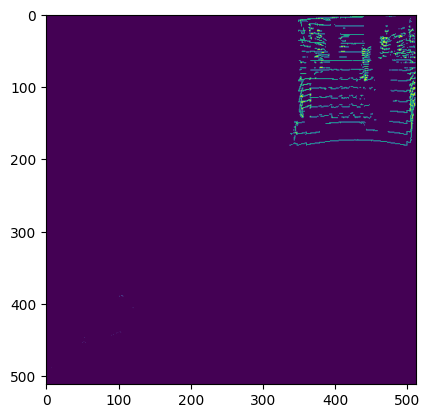

In [ ]:
dept_lidar_r = pts_to_img(pts_lidar_r)
plt.imshow(dept_lidar_r)

In [ ]:
pcd_zed = o3d.io.read_point_cloud(ZED_data)
pts_zed = np.asarray(pcd_zed.points)
print(pts_zed, pts_zed.shape)

[[-2.492405  1.447196 -2.436705]
 [-2.475858  1.441786 -2.427595]
 [-2.469097  1.442058 -2.428054]
 ...
 [ 1.574756 -0.893204 -1.709091]
 [ 1.579812 -0.893185 -1.709056]
 [ 1.584903 -0.893186 -1.709058]] (236969, 3)


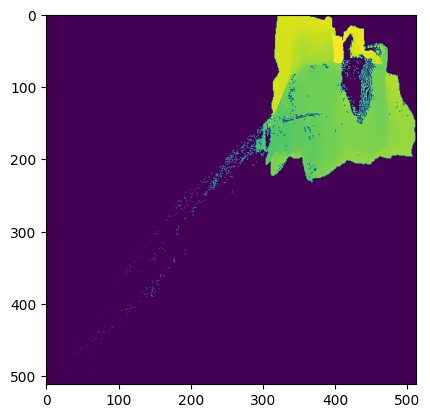

In [ ]:
dept_zed = pts_to_img(pts_zed)
plt.imshow(dept_zed)

In [ ]:
pcd_zed_r = copy.deepcopy(pcd_zed).translate((0, 0, 0))
pcd_zed_r.rotate(pcd_zed_r.get_rotation_matrix_from_xyz((-np.pi / 2, 0, 0)), center=(0, 0, 0))
pts_zed_r = np.asarray(pcd_zed_r.points)

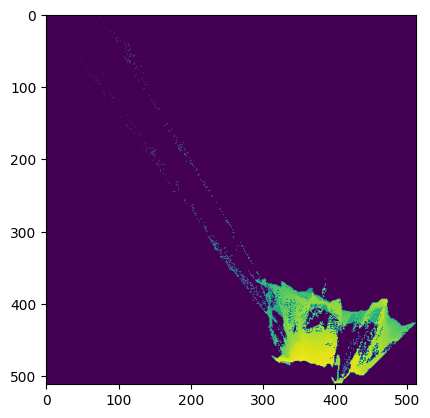

In [ ]:
dept_zed_r = pts_to_img(pts_zed_r)
plt.imshow(dept_zed_r)

In [ ]:
pg_dept_lidar = np.real(pg(dept_lidar, 8, 0.4, 100, threshold=100))
plt.imshow(pg_dept_lidar)

TypeError: lpf() takes 2 positional arguments but 3 were given

In [ ]:
def img_to_pts(image_array):
    # Determine the image resolution
    image_resolution = image_array.shape[:2]

    # Rescale the pixel values to their original range
    z_range = 1.0
    z_scaled = image_array.astype(float) / 255.0 * z_range

    # Rescale the x and y coordinates to their original range
    x_range = image_resolution[0] - 1
    y_range = image_resolution[1] - 1
    x, y = np.meshgrid(np.arange(image_resolution[0]), np.arange(image_resolution[1]), indexing='ij')
    x_scaled = x / x_range * np.max(x_range) + np.min(x_range)
    y_scaled = y / y_range * np.max(y_range) + np.min(y_range)

    # Rescale the z coordinates to their original range
    z = z_scaled / z_range * (np.max(z_range) - np.min(z_range)) + np.min(z_range)

    # Combine the x, y, and z coordinates into a point cloud
    point_cloud_data = np.column_stack((x_scaled.flatten(), y_scaled.flatten(), z.flatten()))

    return point_cloud_data

In [ ]:
pts_lidar_hat = img_to_pts(dept_lidar_r)
pcd_lidar_hat = o3d.geometry.PointCloud()
pcd_lidar_hat.points = o3d.utility.Vector3dVector(pts_lidar_hat)

In [ ]:
o3d.visualization.draw_geometries([
    # coords,
    # pcd_zed,
    # pcd_lidar,
    # pcd_lidar_r,
    pcd_lidar_hat,
])

In [ ]:
def similarity_percentage(pts_1, pts_2):
    # Calculate the RMSE between the original and recovered point clouds
    mse = np.mean((pts_1 - pts_2)**2)
    rmse = np.sqrt(mse)

    # Normalize the RMSE to a similarity percentage between 0 and 100
    similarity_percent = 100.0 * (1.0 - rmse / np.max(pts_1 - np.min(pts_1)))

    return similarity_percent

In [ ]:
print(pts_lidar_r.shape, pts_lidar_hat.shape)

(8707, 3) (262144, 3)


In [ ]:
similarity_percentage(pts_lidar, pts_lidar_hat)

ValueError: operands could not be broadcast together with shapes (8707,3) (262144,3) 